# Homework 05: Confidence Intervals and Sensitivity

## Problem 1

Write a program to calculate an confidence limits at arbitrary confidence levels for a given number of observed counts (remember those are integers).  Calculate upper and lower limits (if possible) at 68% and 95% CL for observed counts between 0 and 10.

Hint: Poisson distribution and stats.xxx.ppf may help

In [1]:
import scipy.stats as stats

In [2]:
def confidence_limits(observed_count, confidence_level):
    """
    Calculate the confidence limits for a given observed count and confidence level.
    
    :param observed_count: Number of observed events (integer).
    :param confidence_level: Desired confidence level (e.g., 0.68 for 68% CL, 0.95 for 95% CL).
    
    :return: Tuple (lower_limit, upper_limit).
    """
    # Implement your code below
    alpha = 1 - confidence_level
    lower_limit = stats.poisson.ppf(alpha / 2, observed_count)
    upper_limit = stats.poisson.ppf(1 - alpha / 2, observed_count)
    
    return lower_limit, upper_limit

In [3]:
assert confidence_limits(100, 0.68) == (90.0, 110.0)
assert confidence_limits(100, 0.95) == (81.0, 120.0)

## Problem 2

In this problem we will do a simplified version of searching for rare event physics signals. In this set up, the background is a flat background in energy space, and the signal we are searching for is a monoenergetic gaussian peak (monoenergetic with energy resolution results in a gaussian peak). We don't consider any efficiency loss (assuming we can detect all signal and background events), and what we are trying to do is to define the models, simulate the "fake" events, then fit the signal rate, and find the upperlimit on the signal rate.

### Part 1

Defining the signal and background models. In those kind of fit (assuming we are using $\chi^2$ fit), binning is important. Suppose you are expecting 1000 flat bakcground events between 100 and 300 GeV, with a 10 GeV binning, how many events are you expecting in each bin?

Note: Carefully deal with bin_edges and bin_centers, len(bin_edges) = len(bin_centers)+1 = n_bins+1

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from iminuit import Minuit

In [5]:
def background(E_min, E_max, n_bins, B):
    '''
    Input:
        E_min, E_max: min and max of the energy range
        n_bins: number of bins within the energy range
        B: background event rate, unit: number of events
    Output:
        bin_centers: array contains the central energy of the energy bins
        bkg_counts: array contains the expected number of backgrounds in each energy bin
    '''
    # Implement your code below
    energies = np.linspace(E_min, E_max, n_bins)
    bkg_counts = np.full(n_bins, B / n_bins)

    return energies, bkg_counts  # Constant background

In [6]:
E_min = 100
E_max = 300
n_bins = 40
B = 2000

In [7]:
energies, bkg_counts = background(E_min, E_max, n_bins, B)
assert len(energies) == n_bins
assert math.isclose(np.sum(bkg_counts), B, abs_tol=1.0)

In [55]:
def signal(E_min, E_max, n_bins, E_0, sigma, S):
    '''
    Input:
        E_min, E_max: min and max of the energy range
        n_bins: number of bins within the energy range
        B: background event rate, unit: number of events
        E_0: the energy of the monoenergetic signal
        sigma: the width of the signal energy spectrum (assuming gaussian)
        S: total number of signal events
    Output:
        bin_centers: array contains the central energy of the energy bins
        signal_counts: array contains the expected number of signals in each energy bin
    '''
    # Implement your code below
    energies = np.linspace(E_min, E_max, n_bins)
    signal_pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((energies - E_0) / sigma) ** 2)
    signal_pdf /= np.sum(signal_pdf)
    signal_counts = S * signal_pdf

    return energies, signal_counts

In [30]:
E_0 = 250
sigma = 10
S = 50

In [56]:
energies, signal_counts = signal(E_min, E_max, n_bins, E_0, sigma, S)
print(np.sum(signal_counts))
assert len(energies) == n_bins
assert math.isclose(np.sum(signal_counts), S, abs_tol=0.1)

50.0


Now we can plot the signal and background model and see how they look like

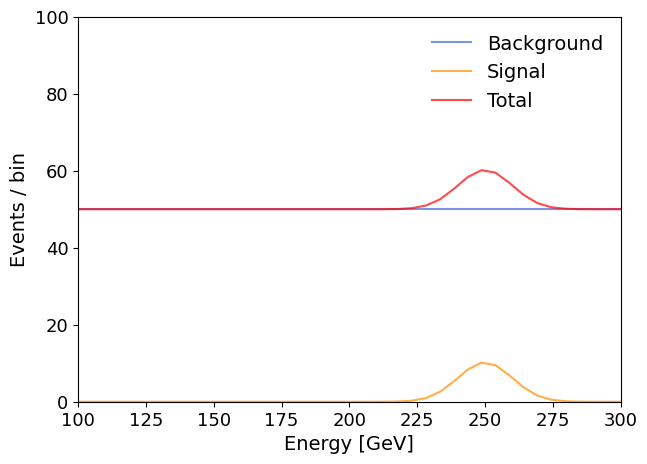

In [57]:
plt.figure(figsize=(7, 5))
plt.plot(energies, bkg_counts, alpha=0.7, color='royalblue', label='Background')
plt.plot(energies, signal_counts, alpha=0.7, color='darkorange', label='Signal')
plt.plot(energies, signal_counts+bkg_counts, alpha=0.7, color='red', label='Total')
plt.xlabel('Energy [GeV]', fontsize=14)
plt.ylabel('Events / bin', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=14)
plt.xlim(100, 300)
plt.ylim(0, 100)
plt.show()

### Part 2

Based on the signal and background model we have defined above, we are able to define our simulation for the "fake" events. Assume for each energy bin the observed number of events follows Poisson(expected), where expected is the number of expected events in the bin.

In [ ]:
def generate_toy_mc(E_min, E_max, n_bins, E_0, sigma, S, B):
    '''
    Input:
        E_min, E_max: min and max of the energy range
        n_bins: number of bins within the energy range
        E_0: energy of the monoenergetic signal
        sigma: width of the signal energy spectrum (assuming Gaussian)
        S: total number of signal events
        B: total number of background events
    Output:
        toy_data: simulated events in each bin, signal_observed + background_observed
    '''
    # Implement your code below
    _, bkg_counts = background(E_min, E_max, n_bins, B)
    _, signal_counts = signal(E_min, E_max, n_bins, E_0, sigma, S)
    toy_data = np.random.poisson(signal_counts + bkg_counts)
    return toy_data

In [58]:
# Set random seed for reproducibility
np.random.seed(42)

observed_counts = generate_toy_mc(E_min, E_max, n_bins, E_0, sigma, S, B)
print(observed_counts, np.sum(observed_counts))
expected_counts = signal_counts+bkg_counts
assert observed_counts[0] == 46
assert observed_counts[-1] == 64
assert np.sum(observed_counts) == 2087

[47 55 42 52 58 43 46 49 52 45 49 43 52 52 46 54 40 45 46 51 64 52 38 33
 48 59 48 46 65 65 66 54 63 48 46 55 60 40 56 56] 2029


AssertionError: 

Now you can plot the "observed" data and compare with the theoretical distribution. The uncertainty (error bar) for each bin count $N_i$ is $\sqrt{N_i}$.

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(energies, bkg_counts, alpha=0.7, color='royalblue', label='Background')
plt.plot(energies, signal_counts, alpha=0.7, color='darkorange', label='Signal')
plt.plot(energies, expected_counts, alpha=0.7, color='red', label='Total')
plt.errorbar(energies, observed_counts, yerr=np.sqrt(observed_counts), 
             fmt='o', linestyle='None',
             alpha=0.7, color='black', label='Observed')
plt.xlabel('Energy [GeV]', fontsize=14)
plt.ylabel('Events / bin', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left', frameon=False, fontsize=14)
plt.xlim(100, 300)
plt.ylim(0, 120)
plt.show()

### Part 3

Now let's define the $\chi$-square function and perform the fit!

In [ ]:
# Define the chi-square function, make use of the functions you defined previously
def chi2(S_fit, B_fit):
    '''
    Input:
        S: total number of signal events
        B: total number of background events
    Output:
        Chi square
    '''
    # Implement your code below
    return chi2_value

In [ ]:
chi2_test = chi2(50, 2000)
assert math.isclose(chi2_test, 48.4744, abs_tol=1e-2)

In [ ]:
# Initial guess of the parameters
S_init = 100
B_init = np.sum(observed_counts)
# Implement your code below (only one line)
minuit = ...
minuit.limits = [(0, None), (0, None)]
minuit.migrad()  # Minimization

# Print the fit results
best_fit_S = minuit.values["S_fit"]
best_fit_B = minuit.values["B_fit"]

print(f"Best-fit S: {best_fit_S:.2f}")
print(f"Best-fit B: {best_fit_B:.2f}")

# Print the best-fit chi-square value
chi2_min = minuit.fval

print (f"Best-fit chi-square: {chi2_min:.2f}")

In [ ]:
assert math.isclose(best_fit_S, 15.99, abs_tol=1e-2)
assert math.isclose(best_fit_B, 2092.99, abs_tol=1e-2)
assert math.isclose(chi2_min, 44.14, abs_tol=1e-2)

### Part 4

As we can see, although we set S=50 and B=2000, after simulating the "observed" data we fit the observed with our signal and background models, the best-fit values we get is not very close to the values we set.

Now, let's go ahead and find the upperlimit on the signal rate at 90% confidence level.

The way we will do this is as follows:
1. Fix a $S_{fit}$ (or $S_{scan}$) value
2. Perform the fit again (here it will be fitting $B_fit$ only
3. Get the best-fit $\chi^2_{fix\ S}$, calculate $q = \chi^2_{fix\ S} - \chi^2_{best-fit}$
4. Look for the $S_{scan}$ value that makes its corresponding $\chi^2$ value larger than best-fit $\chi^2_{best-fit}$ by 2.71 (based on approximation you learned from lecture), i.e. $q=2.71$.

In [ ]:
# Array to store q values for different signal strengths
S_scan = np.linspace(0, 80, 200)  # Test range of signal strengths
q_values = []

for s in S_scan:
    # Implement your code below (replace "..." to your code)
    # Perform a minimization for each fixed S_scan
    # Hint: try Minuit(lambda B_fit: ... ) for a minuit fit with a fixed S_fit parameter
    m_fixed = ...
    m_fixed.limits = [(0, None)]
    m_fixed.migrad()
    chi2_fixed = ...
    
    # Calculate q for this signal rate
    q = ...
    q_values.append(q)

# Plot q vs. signal rate
plt.figure(figsize=(7, 5))
plt.plot(S_scan, q_values, color='black', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()

Now to find the $S_{scan}$ value corresponding to $q=2.7$, in principle one can fit the curve q(S), but to be simple as we have fairly fine scanning values, we can just find the closet one.

In [ ]:
closest_diff = float('inf')
closest_rate = float('inf')
for i in range(len(S_scan)):
    if abs(q_values[i]-2.71) < closest_diff and S_scan[i]>best_fit_S: # Note that the upperlimit has to be greater than S_best-fit
        closest_diff = abs(q_values[i]-2.71)
        closest_rate = S_scan[i]

In [ ]:
print (f"Upper-limit on Signal Rate: {closest_rate:.2f}")
assert math.isclose(closest_rate, 52.66, abs_tol=1e-1)

In [ ]:
# Plot q vs. signal rate and the critial signal rate
plt.figure(figsize=(7, 5))
plt.plot(S_scan, q_values, color='black', linewidth=2)
plt.hlines(2.71, 0, closest_rate, linestyle='--', color='red', alpha=0.8)
plt.vlines(closest_rate, 0, 2.71, linestyle='--', color='red', alpha=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()